In [2]:
%load_ext autoreload
%autoreload 2

# DATA MANIPULATION
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import numpy as np

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

# VIEWING OPTIONS IN THE NOTEBOOK
from sklearn import set_config; set_config(display='diagram')


In [3]:
df = pd.read_csv("merge_iex_censo_banco.csv")

In [4]:
data_mask= df['SG_UF']=="SE" 
data = df[data_mask]



In [5]:
data = data.drop(columns=['Unnamed: 0','CNPJ','CO_ESCOLA','CO_MUNICIPIO'])

In [ ]:
###Retirar os missing -> inputar os valores no banda por banda por klm 
data.isnull().sum().sort_values(ascending=True)/len(data) #NaN percentage for each column

In [29]:
X.shape, y.shape

((15296, 27), (15296,))

In [6]:
from sklearn.model_selection import train_test_split
y = data['IEX']
X = data.drop(columns=['IEX','SG_UF'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [24]:
#we don't have any duplicates or missing values. Let's do the strict minimum of data preprocessing, _i.e._ ***scaling** and move on quickly to the modeling phase.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
X_train_scaled

array([[-1.1161496 ,  0.        , -1.87753773, ..., -0.59572537,
         0.67666947,  0.37909539],
       [ 0.72879556,  0.        , -1.87753773, ..., -0.59572537,
         0.67666947, -0.01681398],
       [ 0.72879556,  0.        ,  0.53261247, ...,  1.67862584,
        -1.4778264 , -0.46622043],
       ...,
       [ 0.72879556,  0.        , -1.87753773, ...,  1.67862584,
         0.67666947, -0.38074897],
       [-1.57738589,  0.        ,  0.53261247, ..., -0.59572537,
         0.67666947, -0.43903576],
       [ 0.72879556,  0.        ,  0.53261247, ...,  1.67862584,
         0.67666947,  2.87190969]])

In [80]:
X_test_scaled

array([[-1.1161496 ,  0.        ,  0.53261247, ..., -0.59572537,
         0.67666947, -0.38388705],
       [-1.1161496 ,  0.        , -1.87753773, ...,  1.67862584,
        -1.4778264 , -0.47061787],
       [ 0.72879556,  0.        ,  0.53261247, ..., -0.59572537,
         0.67666947, -0.0636736 ],
       ...,
       [-1.57738589,  0.        ,  0.53261247, ..., -0.59572537,
         0.67666947, -0.0769382 ],
       [-1.1161496 ,  0.        ,  0.53261247, ..., -0.59572537,
         0.67666947, -0.29069942],
       [ 0.72879556,  0.        ,  0.53261247, ...,  1.67862584,
         0.67666947, -0.41179947]])

In [32]:
y_pred = np.mean(y_train)
print(f'The mean prediction is {y_pred:.3f}')

absolute_error_test_baseline = [np.abs(y_true - y_pred) for y_true in y_test]
mean_absolute_error_test_baseline = np.mean(absolute_error_test_baseline)

print(f'The benchmark mean absolute error is of {mean_absolute_error_test_baseline:.3f}')

The mean prediction is 5.608
The benchmark mean absolute error is of 3.740


In [52]:
from tensorflow.keras import Sequential, layers

def initialize_model(X):

    #################################
    #  1 - Model architecture       #
    #################################
    
    model = Sequential()
    
    # Input Layer
    model.add(layers.Dense(20, activation='relu', input_dim = X.shape[-1]))
    
    # Hidden Layers
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    
    # Predictive Layer
    model.add(layers.Dense(1, activation='linear'))
    
    ##################################
    #  2 - Our recommended compiler  #
    ##################################
    
    model.compile(optimizer='adam',
                  loss='msle')      # directly optimize for the squared log error!
    
    return model


In [53]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks
es = callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [54]:
# 1. Initializing a NeuralNet with its architecture and its compilation method
model = initialize_model(X_train)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 20)                560       
                                                                 
 dense_16 (Dense)            (None, 15)                315       
                                                                 
 dense_17 (Dense)            (None, 15)                240       
                                                                 
 dense_18 (Dense)            (None, 20)                320       
                                                                 
 dense_19 (Dense)            (None, 1)                 21        
                                                                 
Total params: 1,456
Trainable params: 1,456
Non-trainable params: 0
_________________________________________________________________


In [74]:
# 2. Training the model
epochs = 500 #500 tava bagunçado (poucos dados), overfitou em 100 
batch_size = 16

history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = epochs,         # Play with this until your validation loss overfit
                    batch_size = batch_size, # Let's keep a small batch size for faster iterations
                    callbacks = [es],
                    verbose = 0)

In [75]:
history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = epochs,         # Play with this until your validation loss overfit
                    batch_size = batch_size, # Let's keep a small batch size for faster iterations
                    callbacks = [es],
                    verbose = 0)

In [76]:
# 3. Evaluating the model
res = model.evaluate(X_train, y_train, verbose = 0)
print(f"RMLSE achieved after {epochs} epochs = {round(res**0.5,3)}")

RMLSE achieved after 500 epochs = 1.823


In [77]:
# 4. Looking at the lowest loss
minimium_rmlse_val = min(history.history['val_loss'])**0.5
optimal_momentum = np.argmin(history.history['val_loss'])
print(f"Lowest RMLSE achieved = {round(minimium_rmlse_val,3)}")
print(f"This was achieved at the epoch number {optimal_momentum}") 

Lowest RMLSE achieved = 1.811
This was achieved at the epoch number 0


In [78]:
def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

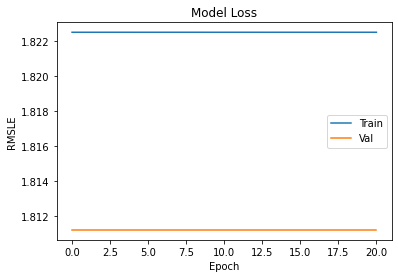

In [79]:
plot_history(history)

In [ ]:
#### Fazer predições
predictions = model.predict(X_test_preproc)
predictions

In [ ]:
# results.to_csv("submission_final.csv", header = True, index = False)
